In [81]:
import numpy 
import pandas 
from sklearn.linear_model import LinearRegression
import seaborn as sns 

import plotly.io as pio
import plotly.express as px 
pio.renderers.default = 'jupyterlab'

from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt

# Discovering causal structures

So if identifying potential confounders and colliders is so important, could we actually discover them, algorithmically, from the data?

Let's create some synthetic data to look into how causal discovery works. This synthetic data is very similar to the previous example: here we have X and Y being spuriously correlated due to effect of W and Z. W and Z are confounding X and Y, whereas X and Y are colliders in the path from W to Z.

In [90]:
N = 10000
rho_wx = 0.5
rho_wy = 0.5
rho_zx = 0.5
rho_zy = 0.5
eta = 1

w = numpy.random.normal(0,1,N)
z = numpy.random.normal(0,1,N) 
x = rho_wx * w + rho_zx * z + eta * numpy.random.normal(0,1,N)
y = rho_wy * w + rho_zy * z + eta * numpy.random.normal(0,1,N)
ya = 0.5 * ( y) + eta * numpy.random.normal(0,1,N)

df = pandas.DataFrame({'z':z,'w':w,'x':x,'y':y, 'ya': ya})
columns = ['x','z','y', 'ya','w']
df = df[columns]

## PC Algorithm for Causal Discovery

The PC algorithm, named after its creators **Peter Spirtes** and **Clark Glymour**, is a constraint-based approach used for causal discovery from observational data. Its goal is to infer a causal structure—typically represented as a Directed Acyclic Graph (DAG)—from observed statistical relationships.

### Steps:

1. **Skeleton Search**:
   - Start with a fully connected undirected graph with each node representing a variable.
   - For each pair of nodes \(X\) and \(Y\):
     * Test independence between \(X\) and \(Y\) given every possible combination of other nodes as conditioning sets.
     * If \(X\) and \(Y\) are conditionally independent given a set \(S\), remove the edge between \(X\) and \(Y\). Record \(S\) as the separator set for that edge.
   - Continue until all pairs of nodes are checked for all possible conditioning set sizes. 


2. **Orientation**:
   - For every trio \(X\), \(Y\), and \(Z\):
     * If \(X\) and \(Z\) are not connected, but both are connected to \(Y\), and \(Y\) is not in the separator set of \(X\) and \(Z\), then orient as \(X &rarr; Y\) and \(Z &rarr; Y\) (indicating a collider).
   - Use additional orientation rules to ensure the graph remains acyclic.


3. **Final Adjustments**:
   - The basic PC algorithm might leave some edges undirected. Extensions can further orient these based on additional rules or heuristics.



We will use [gCastle](
https://github.com/huawei-noah/trustworthyAI/tree/master/gcastle)'s implementation of the PC algorithm. Also take a look at the [causalearn](https://github.com/py-why/causal-learn) package.

In [91]:
from castle.algorithms import PC
from utils import adjacency_to_graph, plot_graph

pc = PC(alpha = 0.001)
pc.learn(df)
graph = adjacency_to_graph( pc.causal_matrix, df.columns )

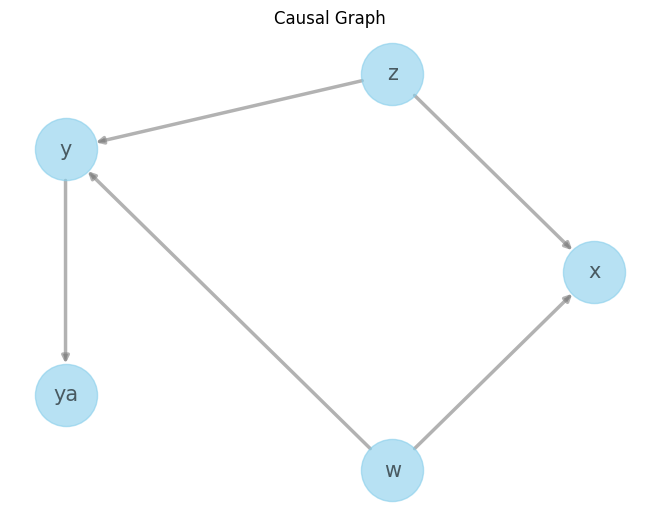

In [92]:
plot_graph(graph)

In [80]:
# pc = PC(alpha = 0.01)
# cols = ['w','x','y']
# pc.learn(df[cols])
# graph = adjacency_to_graph( pc.causal_matrix, cols )
# plot_graph(graph)


## Homework:

- Build your own implementation of the PC algorithm using the conditional independence test we created in the previous notebooks.
- Extend it to support more interesting CI tests: like conditional mutual information.
- Learn about graphical lasso and estimating the precision matrix. (for instance https://skggm.github.io/skggm/tour)
  - How does it relate to what we're trying to do?
  - How could we use this to our advantage?